# Phase 0.2 – Audio Probing with Whisper + Text Encoder

**Goal of this notebook**

1. Load a small audio dataset (LibriSpeech).
2. Use **Whisper encoder** to get fixed-size audio embeddings.
3. Inspect **audio–audio cosine similarity** between clips.
4. Run **Whisper ASR** to transcribe the same clips, and compare:
   - Ground-truth text from LibriSpeech
   - Whisper’s predicted transcript
5. Use a **text encoder (MiniLM)** on the transcripts and compare:
   - Audio embeddings vs text embeddings (audio↔text similarity matrix)

We are not training anything here; we’re only **probing frozen encoders**.


### 1. Setup: Imports & Device


In [23]:
from datasets import load_dataset, Audio
from transformers import WhisperProcessor, WhisperModel, WhisperForConditionalGeneration
from sentence_transformers import SentenceTransformer

import torch
import torchaudio
import librosa
import numpy as np
import io
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Torch: 2.9.0+cu128
CUDA: True


device(type='cuda')

### 2. Phase A – Load a Tiny Audio Dataset (LibriSpeech)

In [3]:
# 2.1 Load LibriSpeech in streaming mode, train.clean.100 split

librispeech = load_dataset(
    "openslr/librispeech_asr",
    "all",
    streaming=True,
    split="train.clean.100"  # large split, but we will only take a few samples
)

# Turn off automatic decoding so we can work with raw bytes
audio_ds = librispeech.decode(False)

# Take 5 examples for this POC
five_examples = list(audio_ds.take(5))

len(five_examples)


Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

5

In [4]:
# 2.2 Inspect a few raw examples

for i, ex in enumerate(five_examples):
    print(f"\nSample {i+1}")
    print("ID:", ex["id"])
    print("Text:", ex["text"])
    # ex["audio"] is dict with 'path' and 'bytes'
    print("Audio keys:", ex["audio"].keys())



Sample 1
ID: 374-180298-0000
Text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Audio keys: dict_keys(['bytes', 'path'])

Sample 2
ID: 374-180298-0001
Text: MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN
Audio keys: dict_keys(['bytes', 'path'])

Sample 3
ID: 374-180298-0002
Text: I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO THINK OVER THE POSITION I HAD ACCEPTED FOR IN SPITE OF MYSELF IT WAS A GREAT DISTRESS TO ME THUS MY LIFE GENERALLY SO CALM
Audio keys: dict_keys(['bytes', 'path'])

Sample 4
ID: 374-180298-0003
Text: ASSUMED ALL AT ONCE AN APPEARANCE OF NOISE AND DISORDER NEVER BELIEVE HOWEVER DISINTERESTED THE LOVE OF A KEPT WOMAN MAY BE THAT IT WILL COST ONE NOTHING
Audio keys: dic

### 3. Phase B – Load Whisper Encoder & Build Audio Embedding Function

#### # 3.1 Load Whisper processor + encoder-only model


In [5]:

model_name = "openai/whisper-tiny"   # or "openai/whisper-base" if you want slightly better quality

# Processor: handles waveform -> log-Mel features
processor = WhisperProcessor.from_pretrained(model_name, use_fast=True)

# Encoder model (we only need the encoder for embeddings)
whisper_encoder_model = WhisperModel.from_pretrained(model_name).to(device)
whisper_encoder_model.eval()

for p in whisper_encoder_model.parameters():
    p.requires_grad = False

print("Loaded Whisper encoder model:", model_name)


Loaded Whisper encoder model: openai/whisper-tiny


#### 3.2 Helper – load waveform from streaming example

In [6]:
# 3.2 Helper: load waveform from streaming example (bytes → waveform)

def load_waveform_from_streaming_example(example, target_sr=16000):
    audio_info = example["audio"]

    audio_bytes = audio_info["bytes"]
    if audio_bytes is None:
        raise ValueError("No audio bytes found in the streaming example.")

    # Wrap bytes into a file-like object
    audio_file = io.BytesIO(audio_bytes)

    # librosa loads and resamples to target_sr
    wav, sr = librosa.load(audio_file, sr=target_sr)

    return wav, target_sr


#### 3.3 Helper – get Whisper encoder embedding (mean-pooled)

In [7]:
# 3.3 Helper: get a fixed-size audio embedding from Whisper encoder

def whisper_embed_waveform(wav, sr):
    # 1. Processor: raw audio → log-Mel features
    inputs = processor(
        wav,
        sampling_rate=sr,
        return_tensors="pt"
    )
    input_features = inputs["input_features"].to(device)  # (1, T_mel, 80)

    # 2. Run only the encoder
    with torch.no_grad():
        enc_out = whisper_encoder_model.encoder(input_features)
        hidden = enc_out.last_hidden_state   # (1, T_enc, d)

    # 3. Mean-pool over time → (1, d)
    emb = hidden.mean(dim=1)  # (1, d)

    # 4. L2-normalize
    emb = emb / emb.norm(dim=-1, keepdim=True)

    return emb.squeeze(0).cpu().numpy()  # (d,)


### 4. Phase C – Build Audio Embedding Matrix & Audio–Audio Similarity

#### 4.1 Compute audio embeddings for the 5 examples

In [8]:
# 4.1 Compute audio embeddings for the 5 examples

audio_embeddings = []
texts = []

for ex in five_examples:
    wav, sr = load_waveform_from_streaming_example(ex, target_sr=16000)
    emb = whisper_embed_waveform(wav, sr)
    audio_embeddings.append(emb)
    texts.append(ex["text"])

audio_embeddings = np.stack(audio_embeddings)
print("Embeddings shape:", audio_embeddings.shape)  # (N, d)
print("First text:", texts[0])


Embeddings shape: (5, 384)
First text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED


#### 4.2 Audio–audio similarity matrix

In [9]:

# 4.2 Compute audio–audio cosine similarity matrix

N = audio_embeddings.shape[0]

# Embeddings are already normalized; dot product = cosine similarity
sim_matrix = audio_embeddings @ audio_embeddings.T
sim_matrix


array([[1.0000006 , 0.987994  , 0.988766  , 0.9757626 , 0.9871941 ],
       [0.987994  , 0.99999994, 0.9843736 , 0.967333  , 0.98079574],
       [0.988766  , 0.9843736 , 1.0000002 , 0.9858894 , 0.98897105],
       [0.9757626 , 0.967333  , 0.9858894 , 0.9999998 , 0.9812445 ],
       [0.9871941 , 0.98079574, 0.98897105, 0.9812445 , 1.0000005 ]],
      dtype=float32)

In [10]:
# 4.3 Create a nice DataFrame with shortened text labels

short_texts = [t[:40] + "..." if len(t) > 40 else t for t in texts]

df_sim = pd.DataFrame(
    sim_matrix,
    index=[f"ex{i}: " + short_texts[i] for i in range(N)],
    columns=[f"ex{i}" for i in range(N)]
)
df_sim


,ex0,ex1,ex2,ex3,ex4
ex0: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF...,1.000001,0.987994,0.988766,0.975763,0.987194
ex1: MARGUERITE TO BE UNABLE TO LIVE APART FR...,0.987994,1.000000,0.984374,0.967333,0.980796
ex2: I WISHED ABOVE ALL NOT TO LEAVE MYSELF T...,0.988766,0.984374,1.000000,0.985889,0.988971
ex3: ASSUMED ALL AT ONCE AN APPEARANCE OF NOI...,0.975763,0.967333,0.985889,1.000000,0.981245
ex4: NOTHING IS SO EXPENSIVE AS THEIR CAPRICE...,0.987194,0.980796,0.988971,0.981245,1.000000


In [11]:
# 4.4 Manually inspect similarity between a few pairs

i, j = 0, 1  # potentially similar (same speaker, close utterances?)
k, l = 0, 4  # potentially less similar

print("sim(i,j) =", float(sim_matrix[i, j]))
print("sim(k,l) =", float(sim_matrix[k, l]))
print("\nText i:", texts[i])
print("Text j:", texts[j])
print("\nText k:", texts[k])
print("Text l:", texts[l])


sim(i,j) = 0.9879940152168274
sim(k,l) = 0.9871941208839417

Text i: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Text j: MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN

Text k: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Text l: NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOWERS BOXES AT THE THEATRE SUPPERS DAYS IN THE COUNTRY WHICH ONE CAN NEVER REFUSE TO ONE'S MISTRESS AS I HAVE TOLD YOU I HAD LITTLE MONEY


### 5. Phase D – Transcribe Audio Clips with Whisper ASR

In [14]:
# 5.1 Load Whisper ASR model (same size as encoder for now)

asr_model_name = "openai/whisper-tiny"

asr_model = WhisperForConditionalGeneration.from_pretrained(asr_model_name).to(device)
asr_model.eval()

for p in asr_model.parameters():
    p.requires_grad = False

print("Loaded ASR model:", asr_model_name)


Loaded ASR model: openai/whisper-tiny


#### 5.2 Helper – transcribe waveform

In [15]:
# 5.2 Helper: transcribe one waveform using Whisper ASR

def whisper_transcribe_waveform(wav, sr, language="en"):
    # 1. waveform → input_features
    inputs = processor(
        wav,
        sampling_rate=sr,
        return_tensors="pt"
    )
    input_features = inputs["input_features"].to(device)

    # 2. Set language + task
    forced_decoder_ids = processor.get_decoder_prompt_ids(
        language=language,
        task="transcribe"
    )

    # 3. Generate token ids
    with torch.no_grad():
        pred_ids = asr_model.generate(
            input_features,
            forced_decoder_ids=forced_decoder_ids
        )

    # 4. Decode to text
    pred_text = processor.batch_decode(pred_ids, skip_special_tokens=True)[0]
    return pred_text


#### 5.3 Compare ground truth vs ASR for each example

In [16]:
# 5.3 Transcribe each example and compare to ground truth

for i, ex in enumerate(five_examples):
    wav, sr = load_waveform_from_streaming_example(ex, target_sr=16000)

    gt_text = ex["text"]
    pred_text = whisper_transcribe_waveform(wav, sr, language="en")

    print(f"\n=== Example {i} ===")
    print("GT:   ", gt_text)
    print("ASR:  ", pred_text)


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



=== Example 0 ===
GT:    CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
ASR:    Chapter 16 I might have told you of the beginning of this liaison in a few lines, but I wanted you to see every step by which we came. I to agree to whatever Mark Reid wished.

=== Example 1 ===
GT:    MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN
ASR:    Margarit to be unable to live apart from me. It was the day after the evening when she came to see me that I sent her a mononless scut. From that time, seeing that I could not change my mistress's life, I changed my own.

=== Example 2 ===
GT:    I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO THINK OVER THE POSITION I HAD ACCEPTED FOR IN SPITE OF MYSELF IT WAS

### 6. Phase E – Compare Audio Embeddings vs Text Embeddings (MiniLM)

#### 6.1 Load a text encoder

In [17]:
# 6.1 Load a sentence encoder for text (MiniLM)

text_model = SentenceTransformer("all-MiniLM-L6-v2")  # small & fast

text_embeddings = text_model.encode(
    texts,
    normalize_embeddings=True  # L2-normalize → cosine = dot product
)

text_embeddings.shape  # (N, d_text)


(5, 384)

#### 6.2 Build audio↔text similarity matrix

In [18]:
from numpy.linalg import norm

# 6.2 Normalize audio + text again for safety
A = audio_embeddings / norm(audio_embeddings, axis=1, keepdims=True)   # (N, d_a)
T = text_embeddings / norm(text_embeddings, axis=1, keepdims=True)     # (N, d_t)

# audio_text_sim[i, j] = cos(audio_i, text_j)
audio_text_sim = A @ T.T   # (N, N)
audio_text_sim.shape


(5, 5)

#### 6.3 Wrap in a DataFrame to inspect audio↔text alignment

In [19]:
# 6.3 DataFrame for audio↔text similarities

df_at = pd.DataFrame(
    audio_text_sim,
    index=[f"audio_ex{i}" for i in range(N)],
    columns=[f"text_ex{j}" for j in range(N)]
)
df_at


,text_ex0,text_ex1,text_ex2,text_ex3,text_ex4
audio_ex0,-0.012998,-0.032815,0.005903,-0.012439,0.014672
audio_ex1,-0.020162,-0.029687,-0.006506,-0.015001,0.015842
audio_ex2,-0.023884,-0.037766,-0.001717,-0.005053,0.006256
audio_ex3,-0.019939,-0.030535,0.006547,0.005151,0.007330
audio_ex4,-0.029884,-0.033821,-0.010715,-0.000369,0.015179


#### 6.4 Inspect top-1 text for each audio embedding

In [20]:
# 6.4 For each audio clip, see which text is most similar

for i in range(N):
    sims = audio_text_sim[i]
    best_j = sims.argmax()
    print(f"\nAudio ex{i} best text ex{best_j} (sim={sims[best_j]:.3f})")
    print("Audio GT text:", texts[i])
    print("Best-matched text:", texts[best_j])



Audio ex0 best text ex4 (sim=0.015)
Audio GT text: CHAPTER SIXTEEN I MIGHT HAVE TOLD YOU OF THE BEGINNING OF THIS LIAISON IN A FEW LINES BUT I WANTED YOU TO SEE EVERY STEP BY WHICH WE CAME I TO AGREE TO WHATEVER MARGUERITE WISHED
Best-matched text: NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOWERS BOXES AT THE THEATRE SUPPERS DAYS IN THE COUNTRY WHICH ONE CAN NEVER REFUSE TO ONE'S MISTRESS AS I HAVE TOLD YOU I HAD LITTLE MONEY

Audio ex1 best text ex4 (sim=0.016)
Audio GT text: MARGUERITE TO BE UNABLE TO LIVE APART FROM ME IT WAS THE DAY AFTER THE EVENING WHEN SHE CAME TO SEE ME THAT I SENT HER MANON LESCAUT FROM THAT TIME SEEING THAT I COULD NOT CHANGE MY MISTRESS'S LIFE I CHANGED MY OWN
Best-matched text: NOTHING IS SO EXPENSIVE AS THEIR CAPRICES FLOWERS BOXES AT THE THEATRE SUPPERS DAYS IN THE COUNTRY WHICH ONE CAN NEVER REFUSE TO ONE'S MISTRESS AS I HAVE TOLD YOU I HAD LITTLE MONEY

Audio ex2 best text ex4 (sim=0.006)
Audio GT text: I WISHED ABOVE ALL NOT TO LEAVE MYSELF TIME TO T

#### 7. (Optional) Simple Heatmaps

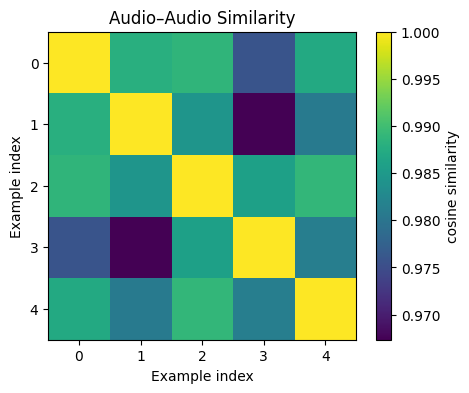

In [24]:
# 7.1 Heatmap for audio–audio similarity

plt.figure(figsize=(5, 4))
plt.imshow(sim_matrix, interpolation="nearest")
plt.colorbar(label="cosine similarity")
plt.title("Audio–Audio Similarity")
plt.xlabel("Example index")
plt.ylabel("Example index")
plt.show()


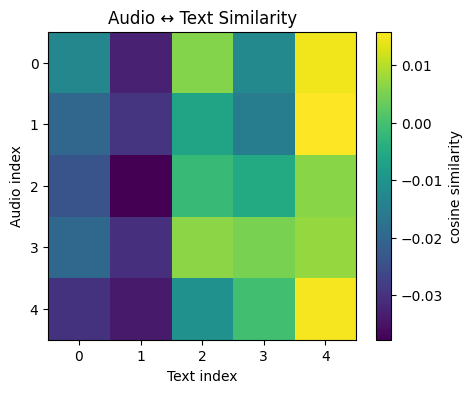

In [25]:
# 7.2 Heatmap for audio↔text similarity

plt.figure(figsize=(5, 4))
plt.imshow(audio_text_sim, interpolation="nearest")
plt.colorbar(label="cosine similarity")
plt.title("Audio ↔ Text Similarity")
plt.xlabel("Text index")
plt.ylabel("Audio index")
plt.show()
